In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objs as go
import plotly.tools as tls
import re
from collections import defaultdict, Counter
from Bio.Seq import Seq
from tqdm import tqdm
from intervaltree import Interval, IntervalTree
from trseeker.seqio.fasta_file import sc_iter_fasta_brute
from trseeker.tools.sequence_tools import get_revcomp
%matplotlib inline

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_online()

In [4]:
fasta_file = "GCF_905171775.1_aRanTem1.1_genomic.fna"
assembled_chromosomes = {}
for header, seq in sc_iter_fasta_brute(fasta_file):
    header = header.split()[0][1:]
    assembled_chromosomes[header] = seq.upper()

probe_47A = "CCATCAAACGCAGCCACTGTGCC"

In [5]:
chroms = {'NC_053489.1': 1, 'NC_053490.1': 2, 'NC_053491.1': 3,
         'NC_053492.1': 4, 'NC_053493.1': 5, 'NC_053494.1': 6,
         'NC_053495.1': 7, 'NC_053496.1': 8, 'NC_053497.1': 9,
         'NC_053498.1': 10, 'NC_053499.1': 11, 'NC_053500.1': 12,
         'NC_053501.1': 13}

In [6]:
positions_f = defaultdict(list)
positions_r = defaultdict(list)
with open('positions.47A.txt') as file:
    line = file.readline().strip()
    line = file.readline().strip()
    while line:
        name = line.split('\t')[1].split()[0]
        pos = int(line.split('\t')[4])
        strand = line.split('\t')[2][-1]
        if strand == 'f':
            positions_f[name].append(pos)
        else:
            positions_r[name].append(pos)
        line = file.readline().strip()

In [7]:
def scaffold_length_sort_length(fasta_file, lenght_cutoff=100000, name_regexp=None, chm2name=None):
    ''' Function that calculates length of scaffolds 
        and return table with scaffold data from fasta file
    '''
    scaffold_length = []
    for header, seq in sc_iter_fasta_brute(fasta_file):
        name = header[1:].split()[0]
        if len(seq) < lenght_cutoff:
            continue
        if name_regexp:
            new_name = re.findall(name_regexp, header)
            if new_name:
                name = new_name[0]
        if chm2name:
            name = chm2name[name]
        scaffold_length.append((name, 1, len(seq)))
        
    scaffold_df = pd.DataFrame(scaffold_length, columns=['scaffold', 'start', 'end'])
    scaffold_df.sort_values(by=['end'], inplace=True, ascending=False)
    return scaffold_df

In [12]:
scaffold_df = scaffold_length_sort_length(fasta_file, lenght_cutoff=120000000)
scaffold_df['chrom'] = scaffold_df.scaffold.apply(lambda x: chroms[x] if x in chroms.keys() else '?')

In [13]:
positions_density = defaultdict(Counter)

for chrom in positions_f.keys():
    for pos in positions_f[chrom]:
        if chrom in chroms:
            n = pos // 10_000_000
            positions_density[chroms[chrom]][n] += 1
for chrom in positions_r.keys():
    for pos in positions_r[chrom]:
        if chrom in chroms:
            n = pos // 10_000_000
            positions_density[chroms[chrom]][n] += 1

In [14]:
def density(pos_density, scaffold_df, title_text, use_chrm=False):

    chrom_name = [i for i in pos_density.keys()]
    yaxis_title = "Chromosome name"

    chomosoms_list = []
    positions_list = []
    density_list = []
    end_list = []
    for chrom in pos_density.keys():
        end = scaffold_df[scaffold_df.chrom==chrom]['end'].values[0]
        n = len(pos_density[chrom])
        chroms = [chrom] * n
        ends = [(d + 1) * 10_000_000 if (d + 1) * 10_000_000 < end else end for d in range(n) ]
        positions = [d * 10_000_000 for d in range(n)]
        densities = [pos_density[chrom][i] for i in range(n)]
    
        chomosoms_list.extend(chroms)
        positions_list.extend(positions)
        density_list.extend(densities)
        end_list.extend(ends)

    fig = go.Figure()
    fig.update_layout(barmode="overlay")
    fig.update_layout(
        title={
            "text": title_text,
            "y": 0.99,
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        xaxis_title="bp",
        yaxis_title=yaxis_title,
    )
    
    fig.add_trace(
        go.Bar(
            base=positions_list,
            x= np.array(end_list) - np.array(positions_list),
            y=chomosoms_list,
            orientation="h",
            name='Density',
            marker={'color': density_list, 'colorscale': 'mint'},
        )
    )
    fig.update_layout(
        xaxis=dict(
            automargin=True,
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor="rgb(204, 204, 204)",
            linewidth=1,
            ticks="outside",
            rangemode="nonnegative",
            tickfont=dict(
                family="Arial",
                size=15,
                color="rgb(82, 82, 82)",
            ),
        ),
        # Turn off everything on y axis
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=True,
            ticklabelstep=1,
            tickwidth=15,
            tickfont=dict(
                family="Arial",
                size=15,
                color="rgb(82, 82, 82)",
            ),
        ),
        width=1400,
        height=900,
        margin=dict(
            autoexpand=True,
            # l=150,
            # r=20,
            # t=110,
        ),
        showlegend=True,
        plot_bgcolor="white",
    )

    fig.update_layout(legend=dict(font=dict(family="Arial", size=15, color="black")))
    fig.update_xaxes(gridcolor='grey', griddash='dash', minor_griddash="dot")
    n_chrom = chrom_name
    fig.update_xaxes(range=[0, max(positions_list) + 10_000_100])
    fig.update_yaxes(tickvals=n_chrom)
    fig.update_yaxes(ticklabelstep=1)
    return fig

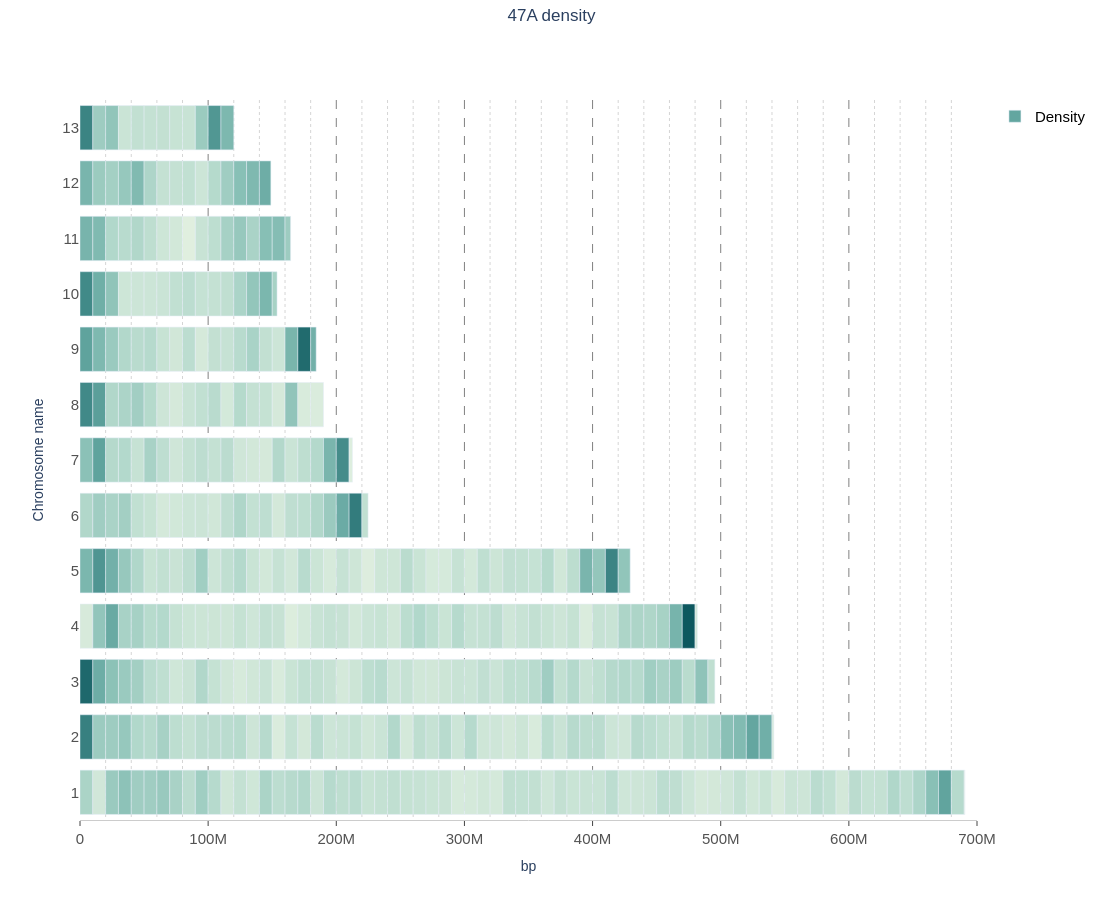

In [15]:
density(positions_density, scaffold_df, '47A density')

In [17]:
te_match = 0
chroms_te = []
for chrom, seq in assembled_chromosomes.items():
    probe = "GTAGCCACTGTGCCCATCAATTGTCGCCACTGTGCTCATCACACGCAGCCACTGTGCCATCACATGCAGCCACTGTGCCCATCAAACGTAGCCACTGTGCCCATCAATTGTCGCCACTGTGCCCATCACATGCAGCCACTGTGCCACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCTCACTGTGCCACCAAACGCAGTCACTGTGCCATCACATGCAGCCACTGTGCCCATCAAAAGCAGCCACTGTGCCCATCAATTGTCGCCACTGTGCCCAAACGCATCCACTGTGCCAATCACACACAGCCACTGTGCCCATCAAACGCAGCCACTGTGCCCATCAATTGTCGCCACTGTGCCACTGTGCCACCATTTTTACTTATGCCATGTGGGTTGATTTTTAGTAATGCCATGTGGGTTAATTTTTACTGATGCCATGTGGGTTGATTTTTAGTAATGCCACGTGGGTTAATTTTTACTGATGCCATGTGGGTTGATTTTTACTGATGCCATGTGGGTTGGTTTTTACTTATGCCATGTGGGTTGATTTTTAGTAATGCCATGTGGGTTGATTTTTGCTAATGCCATGTGGGTTAATTTTTACTGATGCCATGTGGGTTAATTTTTACTAATGCCATGTGGGTTGATTTTTAGTAATGCCATGTGGGTTAATTTTTACTGATGCCATGTGGGTTGGTTTTTACTGATGCCATGTGGGTTAATTTTTACTGATGCCATGTGGGTTAATTTTTACTGATGCCATGTGGGTTGATTTTTACTGATGCCATGTGGGTTGATTTTTACTAATGCCATGTGGGTTGATTTTTACTAATGCTATACCGGTTGATTTTTACTGATGCCATGTGTTTTACTAATGCTATGATGGTTTATTTTTTTATTGCTGCATATTGCTCTTCGCATTACCCTCTCTGGATTGCTTAAGGGCTCTTTCACGCGTCCATTCCGTTCGTCCGTTTTTTGGAC"
    query =  re.compile(probe) 
    te_match += len(query.findall(seq))
    probe = get_revcomp(probe)
    query =  re.compile(probe) 
    count = len(query.findall(seq))
    te_match += count
    if count > 0:
        chroms_te.append(chrom)

In [18]:
chroms_te

['NC_053489.1',
 'NC_053491.1',
 'NW_024404452.1',
 'NC_053493.1',
 'NC_053496.1',
 'NC_053498.1',
 'NW_024404490.1',
 'NC_053500.1',
 'NC_053501.1']

In [19]:
with open('/mnt/data/satelome/users/mpopova/rana/47A/47_in_genome_blast.bed') as f:
    data = f.readlines()

blast_47A = {}
for d in data:
    chrom, start, end = d.strip().split()
    start = int(start)
    end = int(end)
    if start > end:
        inter = start
        start = end
        end = inter
    if not chrom in blast_47A:
        blast_47A[chrom] = IntervalTree([Interval(start, end)])
    else:
        blast_47A[chrom].add(Interval(start, end))

In [20]:
for i in blast_47A:
    blast_47A[i].merge_overlaps()

In [21]:
blast_47A

{'NC_053489.1': IntervalTree([Interval(51318682, 51321594), Interval(61635539, 61638451), Interval(91437899, 91440789), Interval(319867453, 319869485), Interval(525715921, 525717759), Interval(672472687, 672475576), Interval(688417817, 688420055)]),
 'NC_053490.1': IntervalTree([Interval(430331564, 430334453), Interval(430344228, 430347117)]),
 'NC_053491.1': IntervalTree([Interval(136521801, 136523443), Interval(141137463, 141139960), Interval(312828316, 312830570), Interval(367120847, 367123759), Interval(422415365, 422417965), Interval(422417966, 422420855), Interval(437494167, 437497056)]),
 'NC_053492.1': IntervalTree([Interval(303270344, 303273233), Interval(446187351, 446188902)]),
 'NC_053493.1': IntervalTree([Interval(34246534, 34249185), Interval(82700474, 82702971), Interval(89322081, 89324669)]),
 'NC_053495.1': IntervalTree([Interval(37067973, 37070536)]),
 'NC_053496.1': IntervalTree([Interval(11873020, 11875909), Interval(12860810, 12862361), Interval(130110721, 13011360

In [22]:
seq47A = {}
with open("47A_from_genome_upd.fasta") as file:
    name = file.readline().strip()[1:]
    seq = file.readline().strip()
    line = file.readline().strip()
    while line:
        if line.startswith('>'):
            seq47A[name] = seq
            name = line[1:]
        else:
            seq = line
        line = file.readline().strip()
    seq47A[name] = seq

In [23]:
from collections import defaultdict
trf_results = defaultdict(list)
with open("47A_from_genome_upd.fasta.2.5.7.80.10.50.2000.dat") as file:
    data = file.readlines()

In [24]:
name = []
trf = []
for line in data:
    if line.startswith('Sequence'):
        line = line.strip()
        if name:
            trf_results[name] = trf
        name = line[10:]
        trf = []
    elif (line == '\n') or (line.startswith('Param')):
        continue
    else:
        start, end = map(int, line.split()[:2])
        tp =  line.split()[13]                            
        trf.append((tp, start-1, end))    
    trf_results[name] = trf

In [25]:
irf_results = defaultdict(list)
with open("47A_from_genome_upd.fasta.2.7.7.80.10.50.10000.14800.dat") as file:
    data = file.readlines()

name = []
irf = []
for line in data:
    if line.startswith('Sequence'):
        line = line.strip()
        if name:
            irf_results[name] = irf
        name = line[10:]
        irf = []
    elif (line == '\n') or (line.startswith('Param')):
        continue
    else:
        start_forward, end_forward = map(int, line.split()[:2])
        start_reverse, end_reverse = map(int, line.split()[3:5])
        ir_l =  line.split()[17]
        ir_r =  line.split()[18]
        irf.append((ir_l, (start_forward-1, end_forward), (start_reverse-1, end_reverse), ir_r))    
    irf_results[name] = irf

In [26]:
tr = defaultdict(list,
            {'NC_053489.1_319866953_319869485': [('CACTGTGCCCATCAAATGCAGC',
               742,
               1993),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1996, 2460)],
             'NC_053489.1_51318682_51322094': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1992, 2487),
              ('GATGGAAAAACT', 2842, 2892)],
             'NC_053489.1_525715421_525718759': [('CACTGTGCCCATCAAATGTAGC',
               736,
               1617),
              ('CACTGTGCCCATCAAACGCAGC', 1735, 1915),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1918, 2338),
              ('GATGGAAAAACT', 2701, 2762)],
             'NC_053489.1_61635539_61638951': [('CACTGTGCCCATCAAACGTAGC',
               738,
               1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1992, 2487),
              ('GATGGAAAAACT', 2842, 2892)],
             'NC_053489.1_672472687_672476076': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2808, 2869),],
             'NC_053489.1_688417069_688420055': [('CACTGTGCCCATCAAATGTAGC',
               747,
               1236),
              ('CACTGTGCCCATCAAACGCAGC', 1354, 1534),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1545, 2040),
              ('GATGGAAAAACT', 2404, 2465)],
             'NC_053489.1_91437899_91441289': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2809, 2870)],
             'NC_053490.1_430331064_430334453': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053490.1_430343728_430347117': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053491.1_136521073_136523443': [('CACTGTGCCCATCAAACGCAGC',
               734,
               1500),
              ('TGTGCCCATCAAACGCAGCCAC', 1626, 1897),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1900, 2370)],
             'NC_053491.1_141137463_141140698': [('CACTGTGCCCATCAAATGCAGC',
               738,
               1487),
              ('CACTGTGCCCATCAAACGCAGC', 1605, 1785),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1796, 2291),
              ('GATGGAAAAACT', 2654, 2715)],
             'NC_053491.1_312828291_312831474': [('CACTGTGCCCATCAAACGCAGC',
               760,
               1812),
              ('CACTGTGCCCATCAAACGCAGC', 1932, 2112),
              ('ATTTTTACTGATGCCATGTGGGTTG', 2115, 2685),
              ('AAAAACGGATGG', 3043, 3112)],
             'NC_053491.1_367120847_367124259': [('CACTGTGCCCATCAAACGTAGC',
               738,
               1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1992, 2487),
              ('GATGGAAAAACT', 2842, 2892)],
             'NC_053491.1_422415365_422418195': [('ATCAAATGTAGCCACTGTGCCC', 230, 1081),
              ('CACTGTGCCCATCAAACGCAGC', 1199, 1379),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1390, 1885),
              ('GATGGAAAAACT', 2249, 2310)],
             'NC_053491.1_422417941_422421355': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2808, 2869)],
             'NC_053491.1_437494167_437497556': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2808, 2869)],
             'NC_053492.1_303269844_303273233': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053492.1_446186615_446189122': [('CACCCACTGCCTGCCCCTAC',
               2,
               56),
              ('CACTGTGCCCATCAAACGCAGC', 735, 1449),
              ('CATCAATTGCAGCCACTGTGCC', 1557, 1864),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1867, 2431)],
             'NC_053493.1_34246534_34250092': [('CACTGTGCCCATCAAATGCAGC',
               736,
               1810),
              ('CACTGTGCCCATCAAACGCAGC', 1928, 2108),
              ('ATTTTTACTGATGCCATGTGGGTTG', 2119, 2614),
              ('GATGGAAAAACT', 2977, 3038)],
             'NC_053493.1_82700474_82703709': [('CACTGTGCCCATCAAATGCAGC',
               738,
               1487),
              ('CACTGTGCCCATCAAACGCAGC', 1605, 1785),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1796, 2291),
              ('GATGGAAAAACT', 2654, 2715),],
             'NC_053493.1_89321271_89324669': [('CACTGTGCCCATCAAATGTAGC',
               723,
               1712),
              ('CACTGTGCCCATCAAACGCAGC', 1830, 2010),
              ('ATTTTTACTAATGCCATGTGGGTTG', 2013, 2458),
              ('GATGGAAAAACT', 2821, 2882)],
             'NC_053495.1_37067233_37070536': [('CACTGTGCCCATCAAATGTAGC',
               739,
               1554),
              ('CACTGTGCCCATCAAACGCAGC', 1672, 1852),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1863, 2358),
              ('GATGGAAAAACT', 2721, 2782)],
             'NC_053496.1_11873010_11876409': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2808, 2869)],
             'NC_053496.1_12860590_12863096': [('CACTGTGCCCATCAAACGCAGC',
               735,
               1449),
              ('CATCAATTGCAGCCACTGTGCC', 1557, 1864),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1867, 2431)],
             'NC_053496.1_130110221_130113609': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2806, 2867)],
             'NC_053496.1_150860256_150863651': [('CACTGTGCCCATCAAATGTAGC',
               736,
               1725),
              ('CACTGTGCCCATCAAACGCAGC', 1843, 2023),
              ('ATTTTTACTGATGCCATGTGGGTTA', 2026, 2396),
              ('GAAAAACTGAT', 2763, 2831)],
             'NC_053496.1_159453819_159457208': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2808, 2869)],
             'NC_053497.1_63644499_63647898': [('CACTGTGCCCATCAAATGTAGC',
               747,
               1649),
              ('CACTGTGCCCATCAAACGCAGC', 1767, 1947),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1958, 2453),
              ('GATGGAAAAACT', 2817, 2878)],
             'NC_053497.1_72575453_72578813': [('CACTGTGCCCATCAAATGTAGC',
               736,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1940, 2360),
              ('GAAAAACTGAT', 2727, 2795)],
             'NC_053498.1_111004237_111007641': [('CACTGTGCCCATCAAATGTAGC', 737, 1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1984, 2404),
              ('GATGGAAAAACT', 2767, 2828)],
             'NC_053498.1_11655318_11658707': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053498.1_14455595_14459105': [('ATTGTACACCTAGAGGACCCTAGTGTC',
               0,
               53),
              ('CACTGTGCCCATCACACGCAGC', 734, 2218),
              ('CACTGTGCCCATCAAACGCAGC', 2336, 2516),
              ('ATTTTTACTGATGCCATGTGGGTTG', 2519, 3039),
              ('AAAAACTGATGG', 3395, 3463)],
             'NC_053498.1_75823551_75826940': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053498.1_98392197_98395586': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2808, 2869)],
             'NC_053499.1_11390642_11394031': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053499.1_56601609_56604998': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1639),
              ('CACTGTGCCCATCAAACGCAGC', 1757, 1937),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1948, 2443),
              ('GATGGAAAAACT', 2807, 2868)],
             'NC_053500.1_25172221_25175633': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1992, 2487)],
             'NC_053500.1_48397957_48401366': [('CACTGTGCCCATCAAATGCAGC',
               736,
               1659),
              ('CACTGTGCCCATCAAACGCAGC', 1777, 1957),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1968, 2463),
              ('GATGGAAAAACT', 2827, 2888)],
             'NC_053501.1_111545396_111548800': [('CACTGTGCCCATCAAATGTAGC',
               737,
               1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1984, 2404),
              ('GATGGAAAAACT', 2767, 2828)],
             'NC_053501.1_66847696_66851108': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1683),
              ('CACTGTGCCCATCAAACGCAGC', 1801, 1981),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1992, 2487),
              ('GATGGAAAAACT', 2842, 2892)],
             'NC_053501.1_66896873_66900286': [('CACTGTGCCCATCAAATGTAGC',
               739,
               1684),
              ('CACTGTGCCCATCAAACGCAGC', 1802, 1982),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1993, 2488),
              ('GATGGAAAAACT', 2843, 2893)],
             'NW_024404452.1_7042_10430': [('CACTGTGCCCATCAAATGTAGC',
               738,
               1640),
              ('CACTGTGCCCATCAAACGCAGC', 1758, 1938),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1949, 2444),
              ('GATGGAAAAACT', 2807, 2868)],
             'NW_024404490.1_444559_447698': [('CACTGTGCCCATCAAATGCAGC', 467, 1390),
              ('CACTGTGCCCATCAAACGCAGC', 1508, 1688),
              ('ATTTTTACTGATGCCATGTGGGTTG', 1699, 2194),
              ('GATGGAAAAACT', 2558, 2619)]})

In [27]:
length = {}
for key in irf_results.keys():
    start, end = map(int, key.split("_")[2:])
    length[key] = end - start + 1

In [28]:
color_map = {'clust1': '#15daff',
 'clust3': '#627264',
 'clust4': '#a3b1a5',
 'clust5': '#ff4da6',
 '47A': '#B26B8E',
 'clust6': '#707e99'}

In [29]:
clust1 = ['AAAAACGGATGG', 'AAAAACTGATGG', 'GATGGAAAAACT', 'GAAAAACTGAT']
clust2 = ['ATCAAATGTAGCCACTGTGCCC', 'CACTGTGCCCATCAAATGTAGC', 'CATCAATTGCAGCCACTGTGCC', 'CACTGTGCCCATCAAATGCAGC',
         'CACTGTGCCCATCAAACGTAGC', 'TGTGCCCATCAAACGCAGCCAC', 'CACTGTGCCCATCACACGCAGC', 'CACTGTGCCCATCAAACGCAGC']
clust3 = ['ATTGTACACCTAGAGGACCCTAGTGTC', ]
clust4 = ['ATTTTTACTAATGCCATGTGGGTTG', 'ATTTTTACTGATGCCATGTGGGTTG', 'ATTTTTACTGATGCCATGTGGGTTA']
clust5 = ['CACCCACTGCCTGCCCCTAC']
clust6 = ['TCCATCCCACGGTCCCCCTG']

In [30]:
tr_clust = {
    'AAAAACGGATGG': 'clust1',
    'AAAAACTGATGG': 'clust1',
    'ATCAAATGTAGCCACTGTGCCC': '47A',
    'ATTGTACACCTAGAGGACCCTAGTGTC': 'clust3',
    'ATTTTTACTAATGCCATGTGGGTTG': 'clust4',
    'ATTTTTACTGATGCCATGTGGGTTA': 'clust4',
    'ATTTTTACTGATGCCATGTGGGTTG': 'clust4',
    'CACCCACTGCCTGCCCCTAC': 'clust5',
    'CACTGTGCCCATCAAACGCAGC': '47A',
    'CACTGTGCCCATCAAACGTAGC': '47A',
    'CACTGTGCCCATCAAATGCAGC': '47A',
    'CACTGTGCCCATCAAATGTAGC': '47A',
    'CACTGTGCCCATCACACGCAGC': '47A',
    'CATCAATTGCAGCCACTGTGCC': '47A',
    'GAAAAACTGAT': 'clust1',
    'GATGGAAAAACT': 'clust1',
    'TCCATCCCACGGTCCCCCTG': 'clust6',
    'TGTGCCCATCAAACGCAGCCAC': '47A'
}

In [31]:
tr_clusted = {}
for key, value in tr.items():
    tr_clusted[key] = [(tr_clust[x[0]], x[1], x[2]) for x in value]

In [32]:
tr_set = set()
for key, value in tr.items():
    for i in value:
        tr_set.add(i[0])

In [33]:
probe47A = {}
probe = r"CCATCAAACGCAGCCACTGTGCC"
for name, seq in seq47A.items():
    if not probe in seq:
        seq = get_revcomp(seq)
    probe47A[name] = [(m.start(0), m.end(0)) for m in re.finditer(probe, seq)]

In [34]:
new_names = {"NC_053489.1_319866953_319869485": "fwd NC_053489.1_319866953_319869485",
"NC_053489.1_51318682_51322094": "rev NC_053489.1_51318682_51322094",
"NC_053489.1_525715421_525718759": "fwd NC_053489.1_525715421_525718759",
"NC_053489.1_61635539_61638951": "rev NC_053489.1_61635539_61638951",
"NC_053489.1_672472687_672476076": "rev NC_053489.1_672472687_672476076",
"NC_053489.1_688417069_688420055": "fwd NC_053489.1_688417069_688420055",
"NC_053489.1_91437899_91441289": "rev NC_053489.1_91437899_91441289",
"NC_053490.1_430331064_430334453": "fwd NC_053490.1_430331064_430334453",
"NC_053490.1_430343728_430347117": "fwd NC_053490.1_430343728_430347117",
"NC_053491.1_136521073_136523443": "fwd NC_053491.1_136521073_136523443",
"NC_053491.1_141137463_141140698": "rev NC_053491.1_141137463_141140698",
"NC_053491.1_312828291_312831474": "rev NC_053491.1_312828291_312831474",
"NC_053491.1_367120847_367124259": "rev NC_053491.1_367120847_367124259",
"NC_053491.1_422415365_422418195": "rev NC_053491.1_422415365_422418195",
"NC_053491.1_422417941_422421355": "rev NC_053491.1_422417941_422421355",
"NC_053491.1_437494167_437497556": "rev NC_053491.1_437494167_437497556",
"NC_053492.1_303269844_303273233": "fwd NC_053492.1_303269844_303273233",
"NC_053492.1_446186615_446189122": "fwd NC_053492.1_446186615_446189122",
"NC_053493.1_34246534_34250092": "rev NC_053493.1_34246534_34250092",
"NC_053493.1_82700474_82703709": "rev NC_053493.1_82700474_82703709",
"NC_053493.1_89321271_89324669": "fwd NC_053493.1_89321271_89324669",
"NC_053495.1_37067233_37070536": "fwd NC_053495.1_37067233_37070536",
"NC_053496.1_11873010_11876409": "rev NC_053496.1_11873010_11876409",
"NC_053496.1_12860590_12863096": "rev NC_053496.1_12860590_12863096",
"NC_053496.1_130110221_130113609": "fwd NC_053496.1_130110221_130113609",
"NC_053496.1_150860256_150863651": "rev NC_053496.1_150860256_150863651",
"NC_053496.1_159453819_159457208": "rev NC_053496.1_159453819_159457208",
"NC_053497.1_63644499_63647898": "fwd NC_053497.1_63644499_63647898",
"NC_053497.1_72575453_72578813": "fwd NC_053497.1_72575453_72578813",
"NC_053498.1_111004237_111007641": "fwd NC_053498.1_111004237_111007641",
"NC_053498.1_11655318_11658707": "fwd NC_053498.1_11655318_11658707",
"NC_053498.1_14455595_14459105": "rev NC_053498.1_14455595_14459105",
"NC_053498.1_75823551_75826940": "fwd NC_053498.1_75823551_75826940",
"NC_053498.1_98392197_98395586": "rev NC_053498.1_98392197_98395586",
"NC_053499.1_11390642_11394031": "fwd NC_053499.1_11390642_11394031",
"NC_053499.1_56601609_56604998": "fwd NC_053499.1_56601609_56604998",
"NC_053500.1_25172221_25175633": "rev NC_053500.1_25172221_25175633",
"NC_053500.1_48397957_48401366": "fwd NC_053500.1_48397957_48401366",
"NC_053501.1_111545396_111548800": "rev NC_053501.1_111545396_111548800",
"NC_053501.1_66847696_66851108": "rev NC_053501.1_66847696_66851108",
"NC_053501.1_66896873_66900286": "rev NC_053501.1_66896873_66900286",
"NW_024404452.1_7042_10430": "rev NW_024404452.1_7042_10430",
"NW_024404490.1_444559_447698": "rev NW_024404490.1_444559_447698"}

In [36]:
with open('/mnt/data/satelome/users/mpopova/rana/47A/tsd.txt') as file:
          data = file.readlines()

In [37]:
tsd = {}
name = ''
tsd_point = ()
for line in data:
    if line.startswith('>'):
        if name:
            tsd[name] = tsd_point
            tsd_point =()
        name = line.strip()[1:]
    else:
        if tsd_point:
            continue
        tsd_name = line.split()[0]
        start_l, end_l = map(int, line.split(')')[0].split('(')[-1].split('-'))
        start_r, end_r = map(int, line.split('(')[-1].split(')')[0].split('-'))
        tsd_point = (tsd_name, (start_l, end_l), (start_r, end_r))
tsd[name] = tsd_point

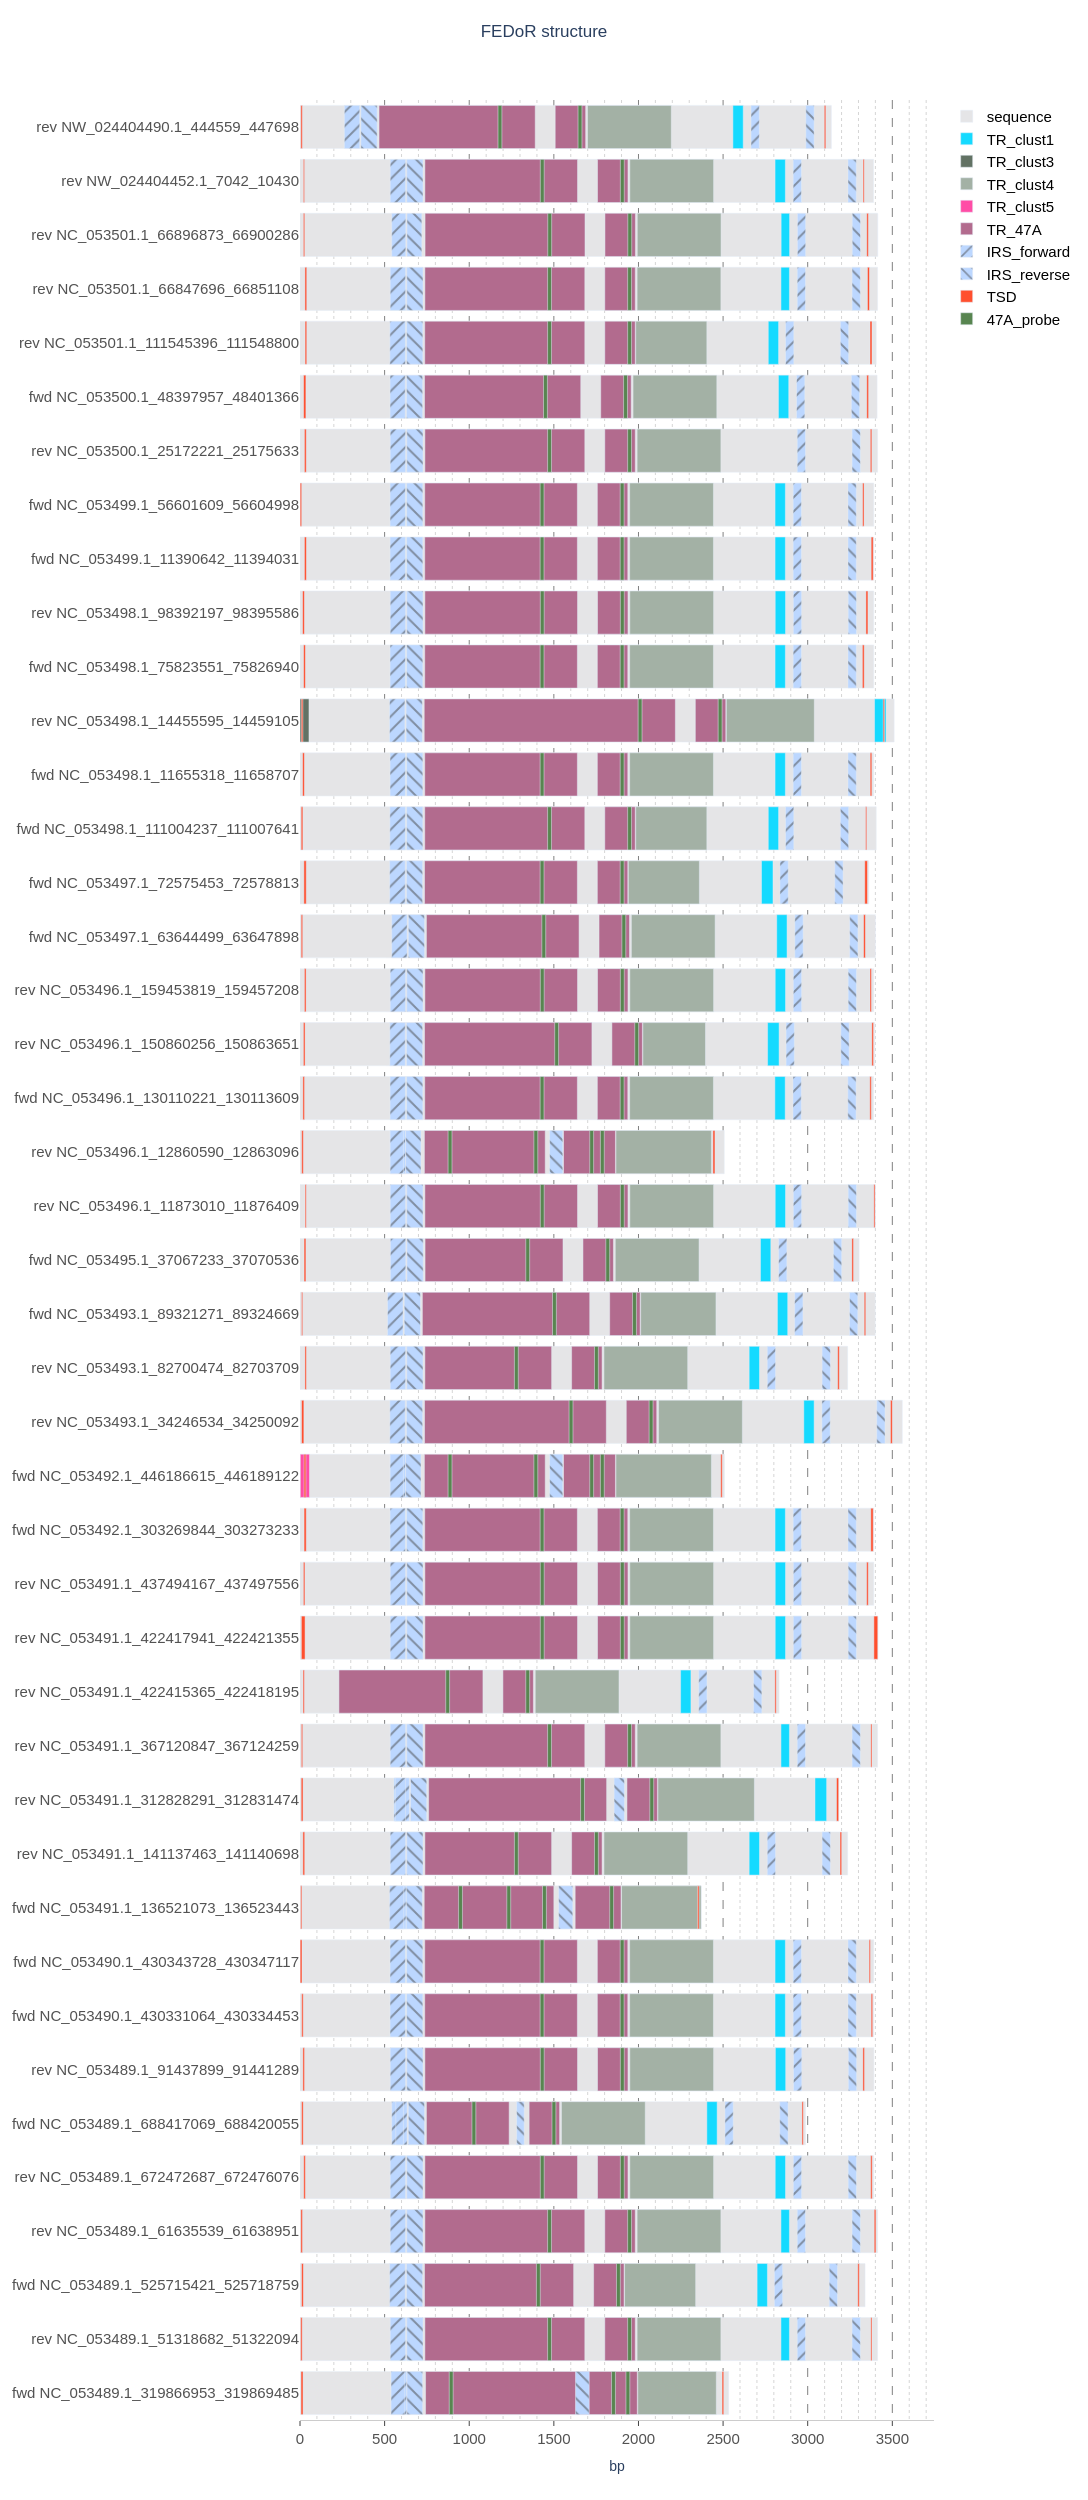

In [40]:
title_text = "FEDoR"
fig = go.Figure()

#making our sequences
probe_values = [x for x in length.values()]
names = [new_names[x] for x in length.keys()]

fig.add_trace(
    go.Bar(
        base=[0],
        x=probe_values,
        y=names,
        orientation="h",
        name='sequence',
        marker_color="#E5E5E7",
    )
)
fig.update_layout(barmode="overlay")
fig.update_layout(
    title={
        "text": "FEDoR structure",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    xaxis_title="bp",
    #yaxis_title='Chromosome',
)

fig.update_layout(
    xaxis=dict(
        automargin=True,
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor="rgb(204, 204, 204)",
        linewidth=1,
        ticks="outside",
        rangemode="nonnegative",
        tickfont=dict(
            family="Arial",
            size=15,
            color="rgb(82, 82, 82)",
        ),
    ),
    # Turn off everything on y axis
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
        ticklabelstep=1,
        tickwidth=15,
        tickfont=dict(
            family="Arial",
            size=15,
            color="rgb(82, 82, 82)",
        ),
    ),
    width=1400,
    height=2500,
    margin=dict(
        autoexpand=True,
        # l=150,
        # r=20,
        # t=110,
    ),
    showlegend=True,
    plot_bgcolor="white",
)

fig.update_layout(legend=dict(font=dict(family="Arial", size=15, color="black")))
fig.update_xaxes(gridcolor='grey', griddash='dash', minor_griddash="dot")
#fig.update_yaxes(tickvals=8)
#fig.update_yaxes(ticklabelstep=1)

for repeat in color_map.keys():
    probe_values = []
    names = []
    
    for key, value in tr_clusted.items():
        for i in value:
            if i[0] ==repeat:
                probe_values.append(i)
                names.append(new_names[key])    
    if names:
        fig.add_trace(
            go.Bar(
                base=[x[1] for x in probe_values],
                x=[x[2] - x[1] for x in probe_values],
                y=names,
                orientation="h",
                name=f'TR_{repeat}',
                #marker_pattern_shape="\\",
                marker_color=color_map[repeat],
            )
        )
    
probe_values = []
names = []

for key, value in irf_results.items():
    for probe in value:
        probe_values.append(probe[1])
        names.append(new_names[key])
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='IRS_forward',
        marker_pattern_shape="/",
        marker_color="#BCD7FF"
    )
)

probe_values = []
names = []

for key, value in irf_results.items():
    for probe in value:
        probe_values.append(probe[2])
        names.append(new_names[key])
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='IRS_reverse',
        marker_pattern_shape="\\",
        marker_color="#BCD7FF",
    )
)

probe_values = []
names = []

for key, value in tsd.items():
    probe_values.append(value[1])
    names.append(new_names[key])
    probe_values.append(value[2])
    names.append(new_names[key])
    
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='TSD',
        #marker_pattern_shape="\\",
        marker_color="#FF4F2E",
    )
)

probe_values = []
names = []

for key, value in probe47A.items():
    for probe in value:
        probe_values.append(probe)
        names.append(new_names[key])
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='47A_probe',
        #marker_pattern_shape="\\",
        marker_color="#588550",
    )
)

output_file_name = title_text + ".jpg"
fig.write_image(output_file_name, format='jpg')
fig.show()

In [41]:
fig.write_image("Possible_te_47A", format='jpg')
fig.write_html('Possible_te_47A.html')

In [42]:
irs_left = {}
for key, value in irf_results.items():
    irs_left[key]= value[0][0]

In [43]:
to_draw = ['NW_024404452.1_7042_10430', 'NW_024404490.1_444559_447698', 'NC_053498.1_14455595_14459105', 'NC_053489.1_688417069_688420055']

In [44]:
irf_results_to_draw = {k: irf_results[k] for k in to_draw}
tr_to_draw = {k: tr_clusted[k] for k in to_draw}
length_to_draw = {k: length[k] for k in to_draw}
probe47A_to_draw = {k: probe47A[k] for k in to_draw}
tsd_to_draw = {k: tsd[k] for k in to_draw}

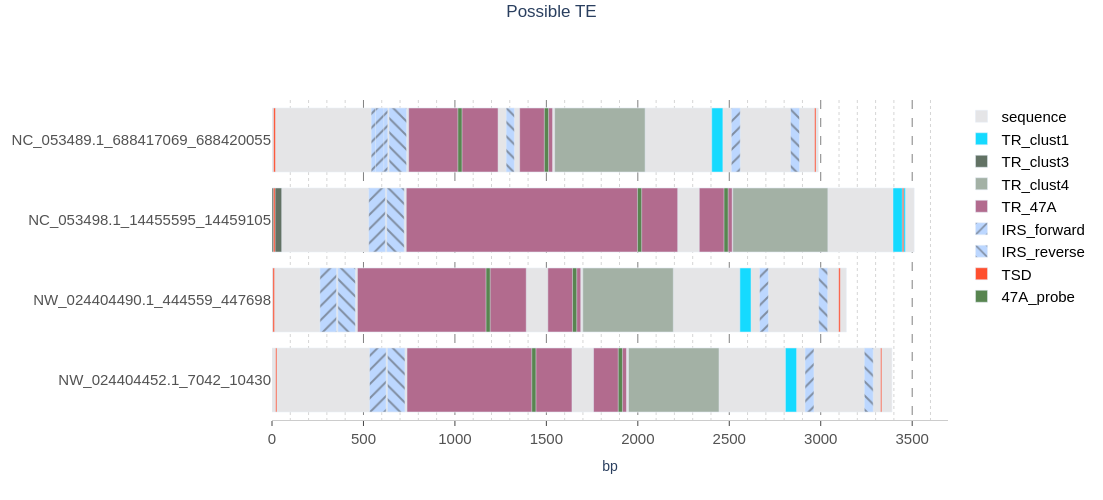

In [45]:
fig = go.Figure()

#making our sequences
probe_values = [x for x in length_to_draw.values()]
names = [x for x in length_to_draw.keys()]

fig.add_trace(
    go.Bar(
        base=[0],
        x=probe_values,
        y=names,
        orientation="h",
        name='sequence',
        marker_color="#E5E5E7",
    )
)
fig.update_layout(barmode="overlay")
fig.update_layout(
    title={
        "text": "Possible TE",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    xaxis_title="bp",
    #yaxis_title='Chromosome',
)

fig.update_layout(
    xaxis=dict(
        automargin=True,
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor="rgb(204, 204, 204)",
        linewidth=1,
        ticks="outside",
        rangemode="nonnegative",
        tickfont=dict(
            family="Arial",
            size=15,
            color="rgb(82, 82, 82)",
        ),
    ),
    # Turn off everything on y axis
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
        ticklabelstep=1,
        tickwidth=15,
        tickfont=dict(
            family="Arial",
            size=15,
            color="rgb(82, 82, 82)",
        ),
    ),
    width=1400,
    height=500,
    margin=dict(
        autoexpand=True,
        # l=150,
        # r=20,
        # t=110,
    ),
    showlegend=True,
    plot_bgcolor="white",
)

fig.update_layout(legend=dict(font=dict(family="Arial", size=15, color="black")))
fig.update_xaxes(gridcolor='grey', griddash='dash', minor_griddash="dot")
#fig.update_yaxes(tickvals=8)
#fig.update_yaxes(ticklabelstep=1)

for repeat in color_map.keys():
    probe_values = []
    names = []
    
    for key, value in tr_to_draw.items():
        for i in value:
            if i[0] ==repeat:
                probe_values.append(i)
                names.append(key)    
    if names:
        fig.add_trace(
            go.Bar(
                base=[x[1] for x in probe_values],
                x=[x[2] - x[1] for x in probe_values],
                y=names,
                orientation="h",
                name=f'TR_{repeat}',
                #marker_pattern_shape="\\",
                marker_color=color_map[repeat],
            )
        )
    
probe_values = []
names = []

for key, value in irf_results_to_draw.items():
    for probe in value:
        probe_values.append(probe[1])
        names.append(key)
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='IRS_forward',
        marker_pattern_shape="/",
        marker_color="#BCD7FF"
    )
)

probe_values = []
names = []

for key, value in irf_results_to_draw.items():
    for probe in value:
        probe_values.append(probe[2])
        names.append(key)
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='IRS_reverse',
        marker_pattern_shape="\\",
        marker_color="#BCD7FF",
    )
)

probe_values = []
names = []

for key, value in tsd_to_draw.items():
    probe_values.append(value[1])
    names.append(key)
    probe_values.append(value[2])
    names.append(key)
    
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='TSD',
        #marker_pattern_shape="\\",
        marker_color="#FF4F2E",
    )
)

probe_values = []
names = []

for key, value in probe47A_to_draw.items():
    for probe in value:
        probe_values.append(probe)
        names.append(key)
fig.add_trace(
    go.Bar(
        base=[x[0] for x in probe_values],
        x=[x[1]-x[0] for x in probe_values],
        y=names,
        orientation="h",
        name='47A_probe',
        #marker_pattern_shape="\\",
        marker_color="#588550",
    )
)

#output_file_name = title_text + ".jpg"
#fig.write_image(output_file_name, format='jpg')
fig.show()

In [46]:
fig.write_image("Possible_te_47A_part", format='jpg')
fig.write_html('Possible_te_47A_part.html')

In [47]:
irs_right = {}
for key, value in irf_results.items():
    irs_right[key] = value[-1][0]

In [48]:
seq0 = {}
for name, seq in seq47A.items():
    irf_point = irf_results[name][0][1][0]
    seq0[name] = seq[:irf_point]

seq0

{'NC_053489.1_319866953_319869485': 'TAACACTGCACAATATGCACTCCTGAGCTCTGTGTTCTGTGTGGTACGCACACGGGCGTAGGAACCGGGGGGGACGGGGGGGACGCATCCCCCCCACGAAAAAATGCGGGGGGGACATGTATGGTAAAATCCCCCCCAGATGTGATTGCGCTCACTAAACTGTGTGCCCGCTGGCGCCGACTAATTGGCTGCCGCGTGCGCTCCTGGCTGGCTCCCTTTCCTCCTGTGCGTCTTCTGGCCCCCCCCATGGAGGATTGAGTTGGTTCATTCCAGTTCCACCGCCGTGCGCCGCGTGACGTCACGCCGGCGGCCGGAGGTGAGAGAGGGAGGAGGGAGCGAGAGTGACTGTCGGCGCCAGTCAGAGTACAAGTTGTGACTCATGGTCACGAGGAGCCTGCTGCTGCGCCTGGGCCTGCCTTACTAATACTGATTACAGTAAAAACTGTCTGCAAGAAGACAGAACCTTCATAAAAAGTAAGAAAGTATTGTGGAGGGGGGAGGGGGGGGTGTGTATTGGACTGAGCTGAGGACCTCAATG',
 'NC_053489.1_51318682_51322094': 'TCCATGCATGCTCAGAATCAAGTCGACGCATGCTTGGAAGCACGGGCGTAGGAACCGGGGGGGACGGGGGGGACGCATCCCCCCCAGGAAATAATGCGGGGGGGACATGTATGGTAAAATCCCCCCCAGATGTGACTGCGCTCACTATACTGTGTGCCCGCTGGCGCCGACTCACTGGCTGCCGCGTGCGCTCCTGGCTGGCTCCCTTTCCTCCGGTGCATCTCCTCGCCCCCCCCCCCATGGAGGATGATTTGGTTCATTCCATTTCCACCGCCGTGCGCCGCGTGACGTCACGCCGGCGGCCGGAGGTGAGAGAGGGAGGAGGGAGGAGGGAGCGAGAGTGACTGTCGGCGCCAGTCAGAGTACAAGCTGTGACTCACGGTCACG

In [49]:
seq1 = {}
for name, seq in seq47A.items():
    tr1_point = tr[name][0][2]
    tr2_point = tr[name][1][1]
    if tr2_point - tr1_point >20:
        seq1[name] = seq[tr1_point:tr2_point]

seq1

{'NC_053489.1_51318682_51322094': 'ACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCT',
 'NC_053489.1_525715421_525718759': 'ACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCT',
 'NC_053489.1_61635539_61638951': 'ACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCT',
 'NC_053489.1_672472687_672476076': 'ACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCT',
 'NC_053489.1_688417069_688420055': 'ACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCT',
 'NC_053489.1_91437899_91441289': 'ACCATTTTTACTGATGCCATGTGGGTTAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTAAAGAAAAAAAAAACATTAATTGCAGCCT',
 'NC_053490.1_430331064_430334453': 'ACCATTTTTACTGATGCCATG

In [50]:
seq2 = {}
for name, seq in seq47A.items():
    if len(tr[name])> 3:
        tr3_point = tr[name][2][2]
        tr4_point = tr[name][3][1]
        if tr4_point - tr3_point >20:
            seq2[name] = seq[tr3_point:tr4_point]

seq2

{'NC_053489.1_51318682_51322094': 'TTTTACTAATGCTATGATGGTTTATTTTTTTATTGCTGCATATTGCTCTTCGCATTACCCTCTCTGGATTGCTTAAGGGCTCTTTCACGCGTCCATTCCGTTCGTCCGTTTTTTGGACGTCCGTTAACGGACCGCAATGCTTCCCTATGGGCTAGCGTCCGTTAGCGGATGAGCATCCGCTAACGTCCGTTAGCATCCGTCTGCGTTCAGTTCCGTTTTTTTGGACGGAAGAAAACCCTATTTTTCTTCCGTCTAATAAACGGAACGGACGAAAAACGGACGTTAACGGATGATCCGTTTATCATCCGTTCCGCTAACATCCGTTTTTCTATGTAAAAAGCCGCAAAAAAAAATG',
 'NC_053489.1_525715421_525718759': 'TTTTACTAATGCTATGATGGTTTATTTTTTTATTGCTGCATATTGCTCTTCGCATTACCCTCTCTGGATTGCTTAAGGGCTCTTTCACGCGTCCATTCCGTTTGTCCGTTTTTTGGACGTCCGTTAACGGACCGCAATGCTTCCCTATGGGCTAGCGTCCGTTAGCGGATGAGCATCCGCTAACGTCCGTTAGCATCCGTCTGCGTTCAGTTCCGTTTTTTTGGACGGAAGAAAACCCTATTTTTCTTCCGTCTAATAAACGGAACGGACGAAAAACGGACGTTAACGGATGATCCGTTTATCATCCGTTCCGCTAACATCCGTTTTTCTATGTAAAAAGCCACAAAAAAACAAAAAAAAATG',
 'NC_053489.1_61635539_61638951': 'TTTTACTAATGCTATGATGGTTTATTTTTTTATTGCTGCATATTGCTCTTCGCATTACCCTCTCTGGATTGCTTAAGGGCTCTTTCACGCGTCCATTCCGTTCGTCCGTTTTTTGGACGTCCGTTAACGGACCGCAATGCTTCCCTATGGGCTAGCGTCCGTTAGCGGA

In [51]:
seq3 = {}
for name, seq in seq47A.items():
    irf_point_f = irf_results[name][-1][1][1]
    irf_point_r = irf_results[name][-1][2][0]
    if irf_point_f > 2000:
        seq3[name] = seq[irf_point_f:irf_point_r]
seq3

{'NC_053489.1_51318682_51322094': 'ATATGAAAAACCGTATGCGGCTGAAACGGACGGGAACGTATGGAACCGCACATATGTACGTTTTCCATTGACATTAATGTTAAAGGAAAACGTATGCGGTTGCCATACTGTTTTAAAAACGACCGCAAAACCGTGGTTGAACACGGTTTTGCGTACGTTTAAAAAACGTTTTGCCAGCAAATCGTACGCACCCGGATGCATCTGAGTGCATACGATTTGCAATGCATTGTCTATCTATACGTTTTCCCGTCCGGGCCCGTACGTTTTCAATACTG',
 'NC_053489.1_525715421_525718759': 'ATATGAAAAACCGTATGCGGCTGAAACGGACGGGAACGTATGGAACCGCACATATGTACGTTTTCCATTGACATTAATGTTAAAGGAAAACGTATGCGGTTGCCATACTGTTTTAAAAACGACCGCAAAACCGTGGTTGAACACGGTTTTGCGTACGTTTAAAAAACGTTTTGCCAGCAAATCGTACGCACCCGGATGCATCTGAGTGCATACGATTTGCAATGCATTCTCTATCTATACGTTTTCCCGTCCGGGCCCGTACGTTTTCGATACTG',
 'NC_053489.1_61635539_61638951': 'ATATGAAAAACCGTATGCGGCTGAAACGGACGGGAACGTATGGAACCGCACATATGTACGTTTTCCATTGACATTAATGTTAAAGGAAAACGTATGCGGTTGCCATACTGTTTTAAAAACGACCGCAAAACCGTGGTTGAACACGGTTTTGCGTACGTTTAAAAAACGTTTTGCCAGCAAATCGTACGCACCCGGATGCATCTGAGTGCATACGATTTGCAATGCATTGTCTATCTATACGTTTTCCCGTCCGGGCCCGTACGTTTTCAATACTG',
 'NC_053489.1_672472687_672476076': 'ATATGAAAAACCGTATGCGGCT

In [52]:
irf_results

defaultdict(list,
            {'NC_053489.1_319866953_319869485': [('TTTTTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACGGCTATTTTTTATTTAAAAAATTATGGTCACCTCAG',
               (538, 631),
               (632, 725),
               'CTGAGATGACCATATTTTTTTAAATAAAAAATAGCCGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTGACTAAAGAAAAAAAAAA'),
              ('TTTTTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACGGCTATTTTTTATTTAAAAAATTA',
               (538, 619),
               (1628, 1709),
               'TAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTGACTAAAGAAAAAAAAAA')],
             'NC_053489.1_51318682_51322094': [('AATGTTTTTTTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACTGCTATATTTAAAAAATTATGGTCACCT',
               (533, 624),
               (631, 727),
               'AGGTGACCATAATTTTTTAAATAAAAAATAGCAGTTTAAAAAAATGTTTGTTATTTTGAGCTTGCCTTCTCTGACTAAAGAAAAAAAAAAAACATT'),
              ('AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
               (2938, 2987),


In [53]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

sequences = [
    'TTTTTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACGGCTATTTTTTATTTAAAAAATTA',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AATGTTTTTTTTTTCTTTAGTGAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACTGCTATTTTTTATTTAAAAAAT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'TTTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACTGCTAT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'TTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACTGCTATTTTTTATTTAAAAAATTA',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCATCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'TTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACTGCTATTTTTTATTTAAAAAATTA',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AATGTTTTTTTTTTTTCTTTAGTCAGAGAAGGCAAGCTCAAAATAACAAACATTTTTTTAAACTGCTATATTTAAAAAATTATGGTCACCT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
'AGGCTGGGTTCACACTACGGTTTTCCCGTCCGTCAGCCGCATACGATTT',
]

scores = []

for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        alignments = pairwise2.align.globalxx(sequences[i], sequences[j])
        max_score = max([alignment[2] for alignment in alignments])
        normalized_score = max_score / max(len(sequences[i]), len(sequences[j]))
        scores.append(normalized_score)

mean_similarity = sum(scores) / len(scores)
print(mean_similarity)

/home/mpopova/miniconda3/envs/jupyter/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning:

Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.



0.8420477191534533
